In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()
import sys

import tensorflow as tf
PROJECT_FOLDER = Path().absolute().parent

sys.path.append(str(PROJECT_FOLDER))

import model_training as mt
from model_training.engine import DataBase

Model Training Package Initialized


In [2]:

DATA_FOLDER = PROJECT_FOLDER / 'model_training' / 'data'
DATA_FILE = DATA_FOLDER / 'master_db.json'
db = DataBase(DATA_FILE)
db

DataBase(c:\Users\User\OneDrive\Desktop\Code\ConnectFour\model_training\data\master_db.json) - 59225 records

In [3]:
raw_data = pd.DataFrame(db.data)
print(raw_data.shape)
raw_data.head(2)

(59225, 9)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN


In [4]:
cols = ['game_id', 'player_one_id', 'player_two_id', 'winner_id',
       'first_mover_id', 'moves', 'turns', 'start_time', 'end_time']

In [5]:
data_df_1 = raw_data.copy()

# Exclude any model that isn't a monte carlo model
p1_monte = data_df_1.player_one_id.str.contains('monte')
p2_monte = data_df_1.player_two_id.str.contains('monte')
data_df_1 = data_df_1[p1_monte & p2_monte].copy()

# Add indicator var if player one is the winner
data_df_1['player_one_win'] = data_df_1.winner_id == data_df_1.player_one_id

print(data_df_1.shape)
data_df_1.head(2)

(58172, 10)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN,False
6,1731877456796490-175216-83d939a1,monte_carlo_100,monte_carlo_200,monte_carlo_200,monte_carlo_100,"[4, 5, 2, 4, 1, 3, 1, 4, 1, 1, 2, 4, 4, 3, 2, ...",18,NaN,NaN,False


In [6]:
data_df_1.tail(2)

,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
59223,1732761780028678-432832-6e7d305f,monte_carlo_200,monte_carlo_150,monte_carlo_200,monte_carlo_200,"[5, 5, 4, 3, 4, 1, 4, 4, 5, 0, 2, 2, 5, 3, 3, ...",17,2024-11-27T20:43:00.028677,2024-11-27T20:43:08.081026,True
59224,1732761788081026-060608-afa6f8c9,monte_carlo_150,monte_carlo_500,monte_carlo_150,monte_carlo_150,"[5, 3, 3, 2, 1, 2, 2, 3, 3, 1, 2, 1, 1, 4, 2, ...",23,2024-11-27T20:43:08.081026,2024-11-27T20:43:28.839080,True


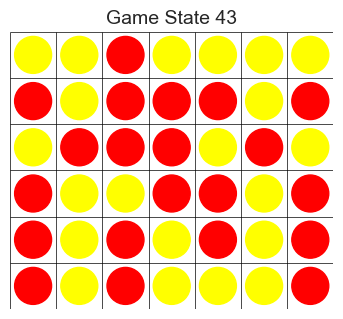

In [7]:
g1 = data_df_1.iloc[0]
moves = g1['moves']
boards = [mt.Board.from_turn_sequence(moves[:i]) for i in range(1, len(moves)+1)]
boards = [mt.Board()] + boards
boards[-1].display_board()

# Make Training Data
Is there a more efficient way to do this sure. But this gets the job done and it's easier to parse I think.

In [8]:
def make_boards(moves) -> list[mt.Board]:
    # boards = [mt.Board.from_turn_sequence(moves[:i]) for i in range(1, len(moves)+1)]
    boards = [mt.Board.from_turn_sequence(moves[:i]) for i in range(1, len(moves))]
    boards = [mt.Board()] + boards
    return boards

def convert_tokens_to_plus_minus(board: mt.Board) -> np.ndarray:
    
    # For all positions that are the current player's token, set it to 1
    # For all positions that are the other player's token, set it to -1
    # For all positions that are empty, they stay at 0
    grid = board.grid.copy()
    
    this_token_mask = grid == board.turn_token
    other_token = mt.board.switch_token(board.turn_token)
    other_token_mask = grid == other_token
    
    grid[this_token_mask] = 1
    grid[other_token_mask] = -1

    return grid


# Iter tuples
X = [] # Game states 
y = [] # Column chosen
for row in data_df_1.itertuples():
    moves = row.moves
    
    # Convert the sequence of moves into a sequence of board states 
    boards = make_boards(moves)

    # Convert the board states from tokens of 1,2,0 to 1,-1,0.
    new_grids = [convert_tokens_to_plus_minus(board) for board in boards]
    X.extend(new_grids)
    
    # This games y values are just the columns that were actually chosen
    y.extend(moves)

# Make sure both are actually numpy arrays and they are the same length
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)
y

(1064337, 6, 7) (1064337,)


array([2, 5, 2, ..., 4, 4, 4])

In [9]:
X = X.reshape(-1, 6, 7, 1)
X.shape

(1064337, 6, 7, 1)

## Check it

In [10]:
data_df_1.turns.iloc[0]

np.int64(42)

In [11]:
X[data_df_1.turns.iloc[0]-1]

array([[[ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.]],

       [[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]],

       [[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.]],

       [[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]],

       [[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]],

       [[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]]])

## Split Dataset

In [12]:
# Train, validation, test split
from sklearn.model_selection import train_test_split

In [13]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-TRAIN_SIZE)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=TEST_SIZE)


# Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Infrastructure

In [15]:


# Define the CNN model
model = Sequential([
    # Input layer: (6, 7, 1)
    tf.keras.Input(shape=(6,7,1)),

    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the 2D feature maps to a 1D vector
    Flatten(),

    # Fully connected (dense) layers
    Dense(128, activation='relu'),
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer: 7 neurons for columns (0-6)
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',  # Adaptive learning rate optimizer
              loss='sparse_categorical_crossentropy',  # For integer labels (0-6)
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 4, 5, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,847 (140.03 KB)

 Trainable params: 35,847 (140.03 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [16]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),verbose=True,batch_size=1000)

Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3154 - loss: 1.7292 - val_accuracy: 0.4631 - val_loss: 1.4264
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4593 - loss: 1.4392 - val_accuracy: 0.4951 - val_loss: 1.3524
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4868 - loss: 1.3791 - val_accuracy: 0.5052 - val_loss: 1.3236
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4987 - loss: 1.3444 - val_accuracy: 0.5167 - val_loss: 1.2885
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5089 - loss: 1.3165 - val_accuracy: 0.5238 - val_loss: 1.2692
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5158 - loss: 1.3001 - val_accuracy: 0.5284 - val_loss: 1.2582
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5193 - loss: 1.2882 - val_accuracy: 0.5313 - val_loss: 1.2500
Epoch 8/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5236 - loss: 1.2765 - 

array([6, 3, 4, ..., 2, 6, 2])

## Eval

In [21]:
y_pred = model.predict(X_test)


666/666 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [27]:
col_preds = pd.Series(y_pred.argmax(axis=1))
col_preds.value_counts(normalize=True)

3    0.367830
2    0.182365
4    0.157232
1    0.120496
0    0.077653
5    0.076479
6    0.017945
Name: proportion, dtype: float64

In [17]:
 # Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.5f}')
print(f'Test accuracy: {accuracy:.5f}')

Test loss: 1.22380
Test accuracy: 0.53986


<Axes: >

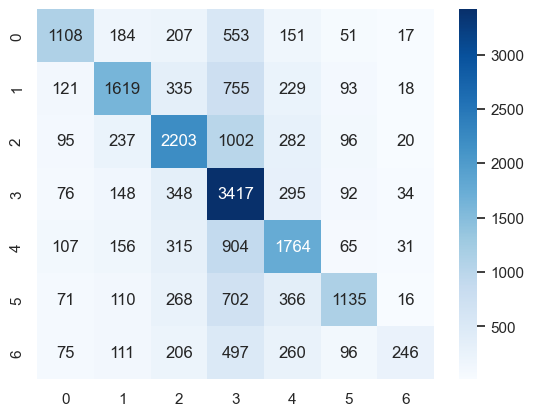

In [29]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, col_preds)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')